In [1]:
from fastai.vision import *
from pathlib import Path
import pickle
import sys
from operator import attrgetter
from PIL import Image as pil_im
import warnings
from IPython.core.debugger import set_trace
PATH = Path('data')
list(PATH.iterdir())

[PosixPath('data/fulltrain'),
 PosixPath('data/image_shapes.pickle'),
 PosixPath('data/validation-annotations-bbox.csv'),
 PosixPath('data/fullvalidation'),
 PosixPath('data/models'),
 PosixPath('data/.ipynb_checkpoints'),
 PosixPath('data/class-descriptions-boxable.csv'),
 PosixPath('data/train-annotations-bbox.csv')]

In [2]:
test_id = "000002b66c9c498e.jpg"
test_id2 = "003c328ea3a0b333.jpg"

print(test_id in os.listdir("data/fulltrain"))
print(test_id in os.listdir("data/fullvalidation"))
print()
print(test_id2 in os.listdir("data/fulltrain"))
print(test_id2 in os.listdir("data/fullvalidation"))

True
False

False
False


In [3]:
# load class names
class_names = pd.read_csv(PATH/'class-descriptions-boxable.csv', header=None, names=["LabelName", "Class"])
class_dict = class_names.set_index('LabelName').to_dict()['Class']

#### Labels, bounding boxes for training

In [4]:
# load training labels
il_train = ImageList.from_folder(PATH/"fulltrain/", convert_mode='L') # change convert_mode to keep all color channels
labels_train = pd.read_csv(PATH/'train-annotations-bbox.csv')
#labels_train = pd.read_csv('test/challenge-2019-train-detection-human-imagelabels.csv')
labels_train['Class'] = [class_dict[item] for item in labels_train.LabelName]
labels_train.loc[:, "ImageID"] = labels_train.loc[:, "ImageID"].astype('category')

# load validation labels
il_val = ImageList.from_folder(PATH/"fullvalidation/", convert_mode='L') # change convert_mode to keep all color channels
labels_val = pd.read_csv(PATH/'validation-annotations-bbox.csv')
#labels_val = pd.read_csv('test/challenge-2019-validation-detection-human-imagelabels.csv')
labels_val['Class'] = [class_dict[item] for item in labels_val.LabelName]
labels_val.loc[:, "ImageID"] = labels_val.loc[:, "ImageID"].astype('category')

In [5]:
test_id = '25c0759ebe00eb5b'

test_id in labels_train["ImageID"].to_list()

False

In [6]:
print(labels_train.shape)
labels_train = labels_train.loc[labels_train["ImageID"].apply(lambda img_id: img_id + '.jpg').isin(os.listdir("data/fulltrain"))]
print(labels_train.shape)

print(labels_val.shape)
labels_val = labels_val.loc[labels_val["ImageID"].apply(lambda img_id: img_id + '.jpg').isin(os.listdir("data/fullvalidation"))]
print(labels_val.shape)

(14610229, 14)
(14607529, 14)
(303980, 14)
(303980, 14)


In [7]:

print(len(set(labels_train.LabelName)))
print(len(set(labels_val.LabelName)))

570
570


In [8]:
print(len(set(labels_train["ImageID"].to_list())))
print(len(os.listdir("data/fulltrain")))

print(len(set(labels_val["ImageID"].to_list())))
print(len(os.listdir("data/fullvalidation")))

1742022
1742022
37306
37306


In [9]:
labels_train.head(3)

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,Class
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,0,0,0,Person
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,0,0,0,Person
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,0,0,0,Person


In [10]:
def save(name, data):
    with open('data/' + name, 'wb') as f:
        pickle.dump(data, f)  
        
def load(name):
    with open('data/' + name, 'rb') as f:
        return pickle.load(f)

In [11]:
def get_XY(directory):
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        corrupted_IDs = []
        X = {}
        Y = {}
        for filepath in directory.iterdir():
            try:
                X[filepath.stem], Y[filepath.stem] = pil_im.open(filepath).size
            except UserWarning:
                print('Image {} corrupted'.format(filepath.name))
                corrupted_IDs.append(filepath.stem)
    return X,Y,corrupted_IDs

In [12]:
if 'image_shapes.pickle' in os.listdir('data') and False:
    X, Y, cIDs = load('image_shapes.pickle')
else:   
    print("getting size of all train images")
    X1,Y1,cIDs1 = get_XY(PATH/'fulltrain')
    # hardcode corrupted image
    X1['7d640caf81d3a97d'] = 2880
    Y1['7d640caf81d3a97d'] = 1920  

    X2,Y2,cIDs2 = get_XY(PATH/'fullvalidation')

    X = {**X1, **X2}
    Y = {**Y1, **Y2}
    cIDs = cIDs1 + cIDs2
    
    with open('data/image_shapes.pickle', 'wb') as f:
        pickle.dump((X, Y, cIDs), f)

getting size of all train images


In [13]:

   
ids_train = list(map(attrgetter('stem'), list(il_train.items)))
df_dict = labels_train.to_dict("list")
x = {image_id : {"bboxes" : [], "Classes" : []} for image_id in ids_train}
[x.update({image_id: {"bboxes" : x[image_id]["bboxes"] + [[ymax*Y[image_id],
                                                           xmin*X[image_id],
                                                           ymin*Y[image_id],
                                                           xmax*X[image_id]]],
                     "Classes" : x[image_id]["Classes"] + [c]}})
 for c, image_id, xmin, xmax, ymin, ymax
 in zip(df_dict["LabelName"], df_dict["ImageID"], 
        df_dict["XMin"], df_dict["XMax"], 
        df_dict["YMin"], df_dict["YMax"])
 if image_id in x
]
img2bbox_train = {image_id : [x[image_id]["bboxes"], x[image_id]["Classes"]] for image_id in ids_train if image_id in x}

#### Labels, bounding boxes for validation

In [14]:
#X,Y,cIDs = get_XY(PATH/'fullvalidation')
ids_val = list(map(attrgetter('stem'), list(il_val.items)))
df_dict = labels_val.to_dict("list")
x = {image_id : {"bboxes" : [], "Classes" : []} for image_id in ids_val}
print(len(ids_val))
print(len(x))
[x.update({image_id: {"bboxes" : x[image_id]["bboxes"] + [[ymax*Y[image_id],
                                                           xmin*X[image_id],
                                                           ymin*Y[image_id],
                                                           xmax*X[image_id]]],
                     "Classes" : x[image_id]["Classes"] + [c]}})
 for c, image_id, xmin, xmax, ymin, ymax
 in zip(df_dict["LabelName"], df_dict["ImageID"], 
        df_dict["XMin"], df_dict["XMax"], 
        df_dict["YMin"], df_dict["YMax"])
]
img2bbox_val = {image_id : [x[image_id]["bboxes"], x[image_id]["Classes"]] for image_id in ids_val}
print(len(img2bbox_val))

37306
37306
37306


In [98]:
len(set(img2bbox_train).intersection(set(img2bbox_val)))

0

In [112]:
img2bbox_val

{'f931e61db43ddd52': [[[388.79999999999995, 0.0, 337.59999744, 1024.0],
   [451.20000000000005, 0.0, 414.3999744000001, 43.2],
   [508.79999999999995, 272.0, 419.20001279999997, 324.8],
   [519.9999744, 332.8, 447.99997440000004, 753.6],
   [526.39997952, 251.2, 459.19999487999996, 785.6],
   [460.79999999999995, 0.0, 435.19999487999996, 64.0],
   [460.79999999999995, 0.0, 438.3999744000001, 44.8],
   [524.80000512, 251.2, 483.19999487999996, 787.2],
   [528.0, 347.2, 457.60002048, 827.2],
   [456.0, 0.0, 422.40000000000003, 62.4],
   [504.0, 272.0, 440.00002559999996, 753.6],
   [524.80000512, 331.2, 462.3999744000001, 675.2]],
  ['/m/01g317',
   '/m/01g317',
   '/m/01g317',
   '/m/01g317',
   '/m/01rzcn',
   '/m/07yv9',
   '/m/019jd',
   '/m/019jd',
   '/m/014y4n',
   '/m/05y5lj',
   '/m/05y5lj',
   '/m/05y5lj']],
 'a21d37cc33f7128f': [[[241.59999743999998, 108.8, 126.40000512, 225.6],
   [241.59999743999998, 0.0, 0.0, 300.8],
   [732.7999872, 164.8, 11.199999744, 886.4]],
  ['/m/083

In [15]:
img2bbox = {**img2bbox_val, **img2bbox_train}

In [16]:
get_y_func = lambda o:img2bbox[o.stem]

In [101]:
print(len(img2bbox.keys()))

print(1742023 + 37306)

1779328
1779329


In [151]:
img2bbox

{'f931e61db43ddd52': [[[388.79999999999995, 0.0, 337.59999744, 1024.0],
   [451.20000000000005, 0.0, 414.3999744000001, 43.2],
   [508.79999999999995, 272.0, 419.20001279999997, 324.8],
   [519.9999744, 332.8, 447.99997440000004, 753.6],
   [526.39997952, 251.2, 459.19999487999996, 785.6],
   [460.79999999999995, 0.0, 435.19999487999996, 64.0],
   [460.79999999999995, 0.0, 438.3999744000001, 44.8],
   [524.80000512, 251.2, 483.19999487999996, 787.2],
   [528.0, 347.2, 457.60002048, 827.2],
   [456.0, 0.0, 422.40000000000003, 62.4],
   [504.0, 272.0, 440.00002559999996, 753.6],
   [524.80000512, 331.2, 462.3999744000001, 675.2]],
  ['/m/01g317',
   '/m/01g317',
   '/m/01g317',
   '/m/01g317',
   '/m/01rzcn',
   '/m/07yv9',
   '/m/019jd',
   '/m/019jd',
   '/m/014y4n',
   '/m/05y5lj',
   '/m/05y5lj',
   '/m/05y5lj']],
 'a21d37cc33f7128f': [[[241.59999743999998, 108.8, 126.40000512, 225.6],
   [241.59999743999998, 0.0, 0.0, 300.8],
   [732.7999872, 164.8, 11.199999744, 886.4]],
  ['/m/083

In [17]:

print(len(os.listdir("data/fulltrain")) + len(os.listdir("data/fullvalidation")))

print(len(img2bbox.keys()))


1779328
1779328


### some classes do not occur in validation set and this will cause an error in training (None)
### The classes are identified and instances belonging to those classes in training set are discarded


In [18]:
image_labels_not_in_val = list(set(labels_train.LabelName).difference(set(labels_val.LabelName)))
corrupted_train_instances = labels_train.loc[labels_train.LabelName.isin(image_labels_not_in_val)]
print(corrupted_train_instances.shape)
corrupted_image_ids = list(set(corrupted_train_instances.ImageID.tolist()))
print(len(corrupted_image_ids))

(0, 14)
0


In [19]:
corrupted_train_instances.head(5)

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,Class


In [20]:
def isListEmpty(inList):
    if isinstance(inList, list): # Is a list
        return all( map(isListEmpty, inList) )
    return False

In [21]:
emptylist = []
for key in img2bbox.keys():
    if isListEmpty(img2bbox[key][0]):
        emptylist.append(key)
print(len(emptylist))


deleted_ids = []                               
for image_id, item in img2bbox.items():
    # [[[538.9965599999999, 9.102336, 20.468, 953.457664]], ['/m/07j7r']]
    # bbox if empty: [[], []]
    if len(item[0]) == 0:
        deleted_ids.append(image_id)
print(len(deleted_ids))        
        
emptylist += corrupted_image_ids

0
0


In [22]:
len(emptylist)

0

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using own ImageBBox class!
[0]
Using ow

KeyboardInterrupt: 

### delete corrupted images

In [23]:

import os
import shutil


def remove_image_by_id(image_id):
    PATH/'fulltrain'/(image_id + '.jpg')
    if os.path.exists(str(PATH/'fulltrain'/(image_id + '.jpg'))):
        print("delete image with ID: ", image_id)
        os.remove(str(PATH/'fulltrain'/(image_id + '.jpg')))
        
    if os.path.exists(str(PATH/'fullvalidation'/(image_id + '.jpg'))):
        print("delete image with ID: ", image_id)
        os.remove(str(PATH/'fullvalidation'/(image_id + '.jpg')))   

deleted_ids = []                               
        
for image_id in emptylist:
    deleted_ids.append(image_id)
    #remove_image_by_id(image_id)
    
    
    
print('number of keys: ', len(img2bbox.keys()))
print('number if images in training set: ', len(list((PATH/"fulltrain").iterdir())))
print('number if images in validation set: ', len(list((PATH/"fullvalidation").iterdir())))
print('total number if images: ', len(list((PATH/"fulltrain").iterdir())) +  len(list((PATH/"fullvalidation").iterdir())) )
print("number of deleted images: ", len(deleted_ids))

number of keys:  1779328
number if images in training set:  1742022
number if images in validation set:  37306
total number if images:  1779328
number of deleted images:  0


In [227]:
data = ObjectItemList.from_folder(path=PATH, convert_mode='RGB') # change convert mode to include/exclude color channels
#data = data.use_partial_data(0.0001) # returns ItemList, but we need ObjectItemList, which is an ImageList, which is an ItemList
data = data.split_by_folder(train='fulltrain', valid='fullvalidation')




In [228]:
data.train = data.train[:200]
data.valid = data.valid[:]
data = data.label_from_func(get_y_func)

In [229]:
idx = []
for i in range(500):
    try:
        print(data.valid.y.__getitem__(i))
        idx.append(i)
        
    except:
        print("error")
       

error
ImageBBox (768, 1024)
error
error
error
error
error
error
ImageBBox (768, 1024)
ImageBBox (819, 1024)
ImageBBox (683, 1024)
ImageBBox (768, 1024)
ImageBBox (768, 1024)
ImageBBox (1024, 769)
ImageBBox (768, 1024)
error
ImageBBox (678, 1024)
ImageBBox (768, 1024)
ImageBBox (768, 1024)
error
ImageBBox (768, 1024)
error
error
ImageBBox (768, 1024)
ImageBBox (1024, 682)
ImageBBox (680, 1024)
ImageBBox (768, 1024)
ImageBBox (614, 1024)
ImageBBox (768, 1024)
ImageBBox (768, 1024)
ImageBBox (1024, 1024)
ImageBBox (768, 1024)
ImageBBox (1024, 1024)
ImageBBox (768, 1024)
error
ImageBBox (586, 1024)
ImageBBox (768, 1024)
ImageBBox (683, 1024)
ImageBBox (768, 1024)
ImageBBox (768, 1024)
ImageBBox (685, 1024)
error
ImageBBox (1024, 683)
ImageBBox (682, 1024)
error
ImageBBox (768, 1024)
ImageBBox (439, 1024)
ImageBBox (765, 1024)
error
ImageBBox (682, 1024)
ImageBBox (768, 1024)
error
error
ImageBBox (683, 1024)
ImageBBox (715, 1024)
ImageBBox (1024, 768)
error
error
ImageBBox (719, 1024)
Imag

In [230]:
data = ObjectItemList.from_folder(path=PATH, convert_mode='RGB') # change convert mode to include/exclude color channels
#data = data.use_partial_data(0.0001) # returns ItemList, but we need ObjectItemList, which is an ImageList, which is an ItemList
data = data.split_by_folder(train='fulltrain', valid='fullvalidation')
data.train = data.train[:200]
data.valid = data.valid[idx]
data = data.label_from_func(get_y_func)

In [232]:
data = data.transform(get_transforms(), size=128, tfm_y=True)
data = data.databunch(path=PATH, bs=16, collate_fn=bb_pad_collate).normalize(imagenet_stats)

In [233]:
data

ImageDataBunch;

Train: LabelList (200 items)
x: ObjectItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ObjectCategoryList
ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128)
Path: data;

Valid: LabelList (316 items)
x: ObjectItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ObjectCategoryList
ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128)
Path: data;

Test: None

In [17]:
data = (ObjectItemList
        .from_folder(path=PATH, convert_mode='RGB') # change convert mode to include/exclude color channels
        .use_partial_data(0.0001)
        #.filter_by_func(lambda ID: Path(ID).stem not in emptylist)
        #.split_by_folder(train='fulltrain', valid='fullvalidation')
        .split_by_rand_pct(0.2)
        .label_from_func(get_y_func)
        .transform(get_transforms(), size=128, tfm_y=True)
        .databunch(path=PATH, bs=16, collate_fn=bb_pad_collate)
        #.normalize(imagenet_stats)
       )

In [18]:
data

TypeError: list indices must be integers or slices, not NoneType

In [74]:
%%script false
with open(PATH/'databunch.pickle', 'wb') as f:
    pickle.dump(data, f)

In [75]:
%%script false
with open(PATH/'databunch.pickle', 'rb') as f:
    data = pickle.load(f)
#data.batch_size = 8

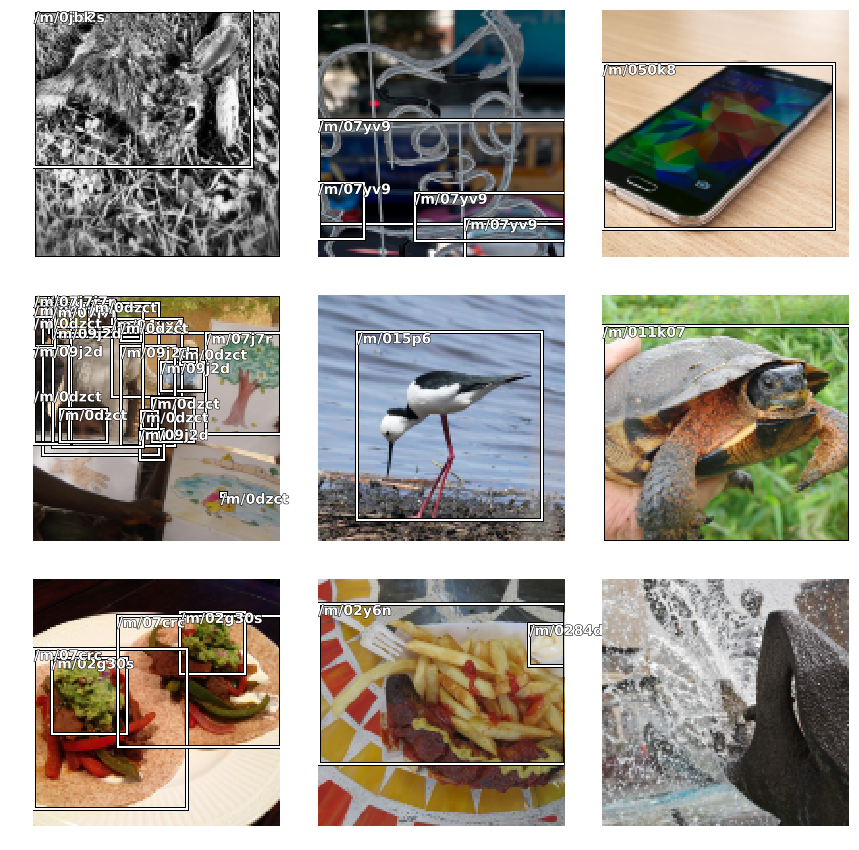

In [234]:
data.show_batch(rows=3, figisze=(2,2))

## Model

The architecture we will use is a [RetinaNet](https://arxiv.org/abs/1708.02002), which is based on a [Feature Pyramid Network](https://arxiv.org/abs/1612.03144). 

![Retina net](images/retinanet.png)

This is a bit like a Unet in the sense we have a branch where the image is progressively reduced then another one where we upsample it again, and there are lateral connections, but we will use the feature maps produced at each level for our final predictions. Specifically, if we start with an image of size (256,256), the traditional resnet has intermediate features maps of sizes:
- C1 (128, 128)  
- C2 (64, 64)
- C3 (32, 32)
- C4 (16, 16)
- C5 (8, 8)
To which the authors add two other features maps C6 and C7 of sizes (4,4) and (2,2) by using stride-2 convolutions. (Note that the model requires an image size of 128 at the minimum because of this.)

Then we have P7 = C7 and we go down from P7 to P2 by upsampling the result of the previous P-layer and adding a lateral connection. The idea is that the last feature map P7 will be responsible to detect big objects, while one like P3 will be responsible to detect smaller objects. 

Each P-something feature map then goes through two subnet of four convolutional layers (with the same weights for all the feature maps), one that will be responsible for finding the category of the object and the other for drawing the bounding box. Each location in the feature map is assigned a given number of anchors (see below) so the classifier ends up with `n_anchors * n_classes` channels and the bounding box regressor with `n_anchors * 4` channels.

In [235]:
#Grab the convenience functions that helps us buil the Unet
from fastai.vision.models.unet import _get_sfs_idxs, model_sizes, hook_outputs

In [236]:
class LateralUpsampleMerge(nn.Module):
    "Merge the features coming from the downsample path (in `hook`) with the upsample path."
    def __init__(self, ch, ch_lat, hook):
        super().__init__()
        self.hook = hook
        self.conv_lat = conv2d(ch_lat, ch, ks=1, bias=True)
    
    def forward(self, x):
        return self.conv_lat(self.hook.stored) + F.interpolate(x, self.hook.stored.shape[-2:], mode='nearest')

In [237]:
class RetinaNet(nn.Module):
    "Implements RetinaNet from https://arxiv.org/abs/1708.02002"
    def __init__(self, encoder:nn.Module, n_classes, final_bias=0., chs=256, n_anchors=9, flatten=True):
        super().__init__()
        self.n_classes,self.flatten = n_classes,flatten
        imsize = (256,256)
        sfs_szs = model_sizes(encoder, size=imsize)
        sfs_idxs = list(reversed(_get_sfs_idxs(sfs_szs)))
        self.sfs = hook_outputs([encoder[i] for i in sfs_idxs])
        self.encoder = encoder
        self.c5top5 = conv2d(sfs_szs[-1][1], chs, ks=1, bias=True)
        self.c5top6 = conv2d(sfs_szs[-1][1], chs, stride=2, bias=True)
        self.p6top7 = nn.Sequential(nn.ReLU(), conv2d(chs, chs, stride=2, bias=True))
        self.merges = nn.ModuleList([LateralUpsampleMerge(chs, sfs_szs[idx][1], hook) 
                                     for idx,hook in zip(sfs_idxs[-2:-4:-1], self.sfs[-2:-4:-1])])
        self.smoothers = nn.ModuleList([conv2d(chs, chs, 3, bias=True) for _ in range(3)])
        self.classifier = self._head_subnet(n_classes, n_anchors, final_bias, chs=chs)
        self.box_regressor = self._head_subnet(4, n_anchors, 0., chs=chs)
        
    def _head_subnet(self, n_classes, n_anchors, final_bias=0., n_conv=4, chs=256):
        "Helper function to create one of the subnet for regression/classification."
        layers = [conv_layer(chs, chs, bias=True, norm_type=None) for _ in range(n_conv)]
        layers += [conv2d(chs, n_classes * n_anchors, bias=True)]
        layers[-1].bias.data.zero_().add_(final_bias)
        layers[-1].weight.data.fill_(0)
        return nn.Sequential(*layers)
    
    def _apply_transpose(self, func, p_states, n_classes):
        #Final result of the classifier/regressor is bs * (k * n_anchors) * h * w
        #We make it bs * h * w * n_anchors * k then flatten in bs * -1 * k so we can contenate
        #all the results in bs * anchors * k (the non flatten version is there for debugging only)
        if not self.flatten: 
            sizes = [[p.size(0), p.size(2), p.size(3)] for p in p_states]
            return [func(p).permute(0,2,3,1).view(*sz,-1,n_classes) for p,sz in zip(p_states,sizes)]
        else:
            return torch.cat([func(p).permute(0,2,3,1).contiguous().view(p.size(0),-1,n_classes) for p in p_states],1)
    
    def forward(self, x):
        c5 = self.encoder(x)
        p_states = [self.c5top5(c5.clone()), self.c5top6(c5)]
        p_states.append(self.p6top7(p_states[-1]))
        for merge in self.merges: p_states = [merge(p_states[0])] + p_states
        for i, smooth in enumerate(self.smoothers[:3]):
            p_states[i] = smooth(p_states[i])
        return [self._apply_transpose(self.classifier, p_states, self.n_classes), 
                self._apply_transpose(self.box_regressor, p_states, 4),
                [[p.size(2), p.size(3)] for p in p_states]]
    
    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()

The model is a bit complex, but that's not the hardest part. It will spit out an absurdly high number of predictions: for the features P3 to P7 with an image size of 256, we have `32*32 + 16*16 + 8*8 + 4*4 +2*2` locations possible in one of the five feature maps, which gives 1,364 possible detections, multiplied by the number of anchors we choose to attribute to each location (9 below), which makes 12,276 possible hits.

A lot of those aren't going to correspond to any object in the picture, and we need to somehow match all those predictions to either nothing or a given bounding box in the picture.

## "Encore" boxes

If we look at the feature map of size `4*4`, we have 16 locations numbered like below: 

In [238]:
torch.arange(0,16).long().view(4,4)

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]])

The most basic way to map one of these features with an actual area inside the image is to create the regular 4 by 4 grid. Our convention is that `y` is first (like in numpy or PyTorch), and that all coordinates are scaled from -1 to 1 (-1 being top/right, 1 being bottom/left). 

In [239]:
def create_grid(size):
    "Create a grid of a given `size`."
    H, W = size if is_tuple(size) else (size,size)
    grid = FloatTensor(H, W, 2)
    linear_points = torch.linspace(-1+1/W, 1-1/W, W) if W > 1 else tensor([0.])
    grid[:, :, 1] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, 0])
    linear_points = torch.linspace(-1+1/H, 1-1/H, H) if H > 1 else tensor([0.])
    grid[:, :, 0] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, 1])
    return grid.view(-1,2)

Let's use a helper function to draw those anchors:

In [240]:
def show_anchors(ancs, size):
    _,ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xticks(np.linspace(-1,1, size[1]+1))
    ax.set_yticks(np.linspace(-1,1, size[0]+1))
    ax.grid()
    ax.scatter(ancs[:,1], ancs[:,0]) #y is first
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1) #-1 is top, 1 is bottom
    for i, (x, y) in enumerate(zip(ancs[:, 1], ancs[:, 0])): ax.annotate(i, xy = (x,y))

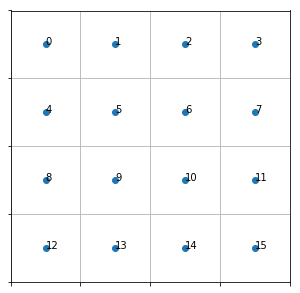

In [241]:
size = (4,4)
show_anchors(create_grid(size), size)

In practice, we use different ratios and scales of that basic grid to build our anchors, because bounding boxes aren't always a perfect square inside a grid. 

In [242]:
def create_anchors(sizes, ratios, scales, flatten=True):
    "Create anchor of `sizes`, `ratios` and `scales`."
    aspects = [[[s*math.sqrt(r), s*math.sqrt(1/r)] for s in scales] for r in ratios]
    aspects = torch.tensor(aspects).view(-1,2)
    anchors = []
    for h,w in sizes:
        #4 here to have the anchors overlap.
        sized_aspects = 4 * (aspects * torch.tensor([2/h,2/w])).unsqueeze(0)
        base_grid = create_grid((h,w)).unsqueeze(1)
        n,a = base_grid.size(0),aspects.size(0)
        ancs = torch.cat([base_grid.expand(n,a,2), sized_aspects.expand(n,a,2)], 2)
        anchors.append(ancs.view(h,w,a,4))
    return torch.cat([anc.view(-1,4) for anc in anchors],0) if flatten else anchors

In [243]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)] 
#Paper used [1,2**(1/3), 2**(2/3)] but a bigger size (600) too, so the largest feature map gave anchors that cover less of the image.
sizes = [(2**i,2**i) for i in range(5)]
sizes.reverse() #Predictions come in the order of the smallest feature map to the biggest
anchors = create_anchors(sizes, ratios, scales)

In [244]:
anchors.size()

torch.Size([3069, 4])

That's a bit less than in our computation earlier, but this is because it's for the case of (128,128) images (sizes go from (1,1) to (32,32) instead of (2,2) to (64,64)).

In [245]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_color = 12
cmap = get_cmap(num_color)
color_list = [cmap(float(x)) for x in range(num_color)]

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [246]:
def show_boxes(boxes):
    "Show the `boxes` (size by 4)"
    _, ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1)
    for i, bbox in enumerate(boxes):
        bb = bbox.numpy()
        rect = [bb[1]-bb[3]/2, bb[0]-bb[2]/2, bb[3], bb[2]]
        draw_rect(ax, rect, color=color_list[i%num_color])
        draw_text(ax, [bb[1]-bb[3]/2,bb[0]-bb[2]/2], str(i), color=color_list[i%num_color])

Here is an example of the 9 anchor boxes with different scales/ratios on one region of the image. Now imagine we have this at every location of each of the feature maps.

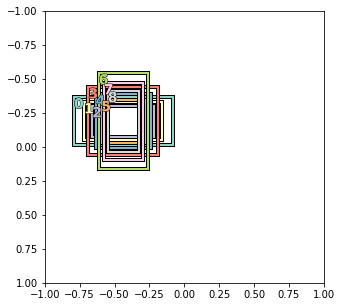

In [247]:
show_boxes(anchors[900:909])

For each anchor, we have one class predicted by the classifier and 4 floats `p_y,p_x,p_h,p_w` predicted by the regressor. If the corresponding anchor as a center in `anc_y`, `anc_x` with dimensions `anc_h`, `anc_w`, the predicted bounding box has those characteristics:
```
center = [p_y * anc_h + anc_y, p_x * anc_w + anc_x]
height = anc_h * exp(p_h)
width  = anc_w * exp(p_w)
```
The idea is that a prediction of `(0,0,0,0)` corresponds to the anchor itself.

The next function converts the activations of the model in bounding boxes.

In [248]:
def activ_to_bbox(acts, anchors, flatten=True):
    "Extrapolate bounding boxes on anchors from the model activations."
    if flatten:
        acts.mul_(acts.new_tensor([[0.1, 0.1, 0.2, 0.2]])) #Can't remember where those scales come from, but they help regularize
        centers = anchors[...,2:] * acts[...,:2] + anchors[...,:2]
        sizes = anchors[...,2:] * torch.exp(acts[...,:2])
        return torch.cat([centers, sizes], -1)
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

Here is an example with the 3 by 4 regular grid and random predictions.

In [249]:
size=(3,4)
anchors = create_grid(size)
anchors = torch.cat([anchors, torch.tensor([2/size[0],2/size[1]]).expand_as(anchors)], 1)
activations = torch.randn(size[0]*size[1], 4) * 0.1
bboxes = activ_to_bbox(activations, anchors)

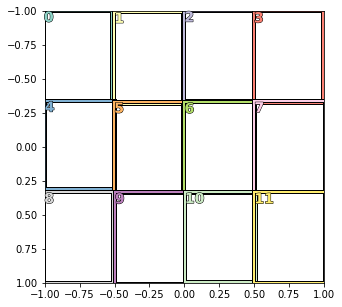

In [250]:
show_boxes(bboxes)

This helper function changes boxes in the format center/height/width to top/left/bottom/right.

In [251]:
def cthw2tlbr(boxes):
    "Convert center/size format `boxes` to top/left bottom/right corners."
    top_left = boxes[:,:2] - boxes[:,2:]/2
    bot_right = boxes[:,:2] + boxes[:,2:]/2
    return torch.cat([top_left, bot_right], 1)

Now to decide which predicted bounding box will match a given ground truth object, we will compute the intersection over unions ratios between all the anchors and all the targets, then we will keep the ones that have an overlap greater than a given threshold (0.5).

In [252]:
def intersection(anchors, targets):
    "Compute the sizes of the intersections of `anchors` by `targets`."
    ancs, tgts = cthw2tlbr(anchors), cthw2tlbr(targets)
    a, t = ancs.size(0), tgts.size(0)
    ancs, tgts = ancs.unsqueeze(1).expand(a,t,4), tgts.unsqueeze(0).expand(a,t,4)
    top_left_i = torch.max(ancs[...,:2], tgts[...,:2])
    bot_right_i = torch.min(ancs[...,2:], tgts[...,2:])
    sizes = torch.clamp(bot_right_i - top_left_i, min=0) 
    return sizes[...,0] * sizes[...,1]

Let's see some results, if we have our 12 anchors from before...

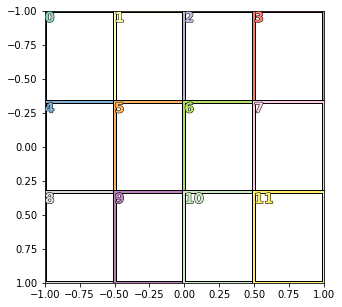

In [253]:
show_boxes(anchors)

... and those targets (0. is the whole image)

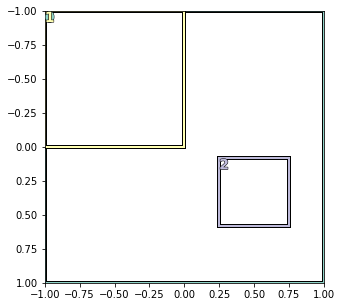

In [254]:
targets = torch.tensor([[0.,0.,2.,2.], [-0.5,-0.5,1.,1.], [1/3,0.5,0.5,0.5]])
show_boxes(targets)

Then the intersections of each bboxes by each targets are:

In [255]:
intersection(anchors, targets)

tensor([[0.3333, 0.3333, 0.0000],
        [0.3333, 0.3333, 0.0000],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.1667, 0.0000],
        [0.3333, 0.1667, 0.0000],
        [0.3333, 0.0000, 0.0625],
        [0.3333, 0.0000, 0.0625],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0625],
        [0.3333, 0.0000, 0.0625]])

In [256]:
def IoU_values(anchors, targets):
    "Compute the IoU values of `anchors` by `targets`."
    inter = intersection(anchors, targets)
    anc_sz, tgt_sz = anchors[:,2] * anchors[:,3], targets[:,2] * targets[:,3]
    union = anc_sz.unsqueeze(1) + tgt_sz.unsqueeze(0) - inter
    return inter/(union+1e-8)

And then the IoU values are.

In [257]:
IoU_values(anchors, targets)

tensor([[0.0833, 0.3333, 0.0000],
        [0.0833, 0.3333, 0.0000],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.1429, 0.0000],
        [0.0833, 0.1429, 0.0000],
        [0.0833, 0.0000, 0.1200],
        [0.0833, 0.0000, 0.1200],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.0000, 0.1200],
        [0.0833, 0.0000, 0.1200]])

Then we match a anchor to targets with the following rules:
- for each anchor we take the maximum overlap possible with any of the targets.
- if that maximum overlap is less than 0.4, we match the anchor box to background, the classifier's target will be that class
- if the maximum overlap is greater than 0.5, we match the anchor box to that ground truth object. The classifier's target will be the category of that target
- if the maximum overlap is between 0.4 and 0.5, we ignore that anchor in our loss computation
- optionally, we force-match for each ground truth object the anchor that has the maximum overlap with it (not sure it helps)

In [258]:
def match_anchors(anchors, targets, match_thr=0.5, bkg_thr=0.4):
    "Match `anchors` to targets. -1 is match to background, -2 is ignore."
    matches = anchors.new(anchors.size(0)).zero_().long() - 2
    if targets.numel() == 0: return matches
    ious = IoU_values(anchors, targets)
    vals,idxs = torch.max(ious,1)
    matches[vals < bkg_thr] = -1
    matches[vals > match_thr] = idxs[vals > match_thr]
    #Overwrite matches with each target getting the anchor that has the max IoU.
    #vals,idxs = torch.max(ious,0)
    #If idxs contains repetition, this doesn't bug and only the last is considered.
    #matches[idxs] = targets.new_tensor(list(range(targets.size(0)))).long()
    return matches

In our previous example, no one had an overlap > 0.5, so unless we use the special rule commented out, there are no matches.

In [259]:
match_anchors(anchors, targets)

tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

With anchors very close to the targets.

In [260]:
size=(3,4)
anchors = create_grid(size)
anchors = torch.cat([anchors, torch.tensor([2/size[0],2/size[1]]).expand_as(anchors)], 1)
activations = 0.1 * torch.randn(size[0]*size[1], 4)
bboxes = activ_to_bbox(activations, anchors)
match_anchors(anchors,bboxes)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

With anchors in the grey area.

In [261]:
anchors = create_grid((2,2))
anchors = torch.cat([anchors, torch.tensor([1.,1.]).expand_as(anchors)], 1)
targets = anchors.clone()
anchors = torch.cat([anchors, torch.tensor([[-0.5,0.,1.,1.8]])], 0)
match_anchors(anchors,targets)

tensor([ 0,  1,  2,  3, -2])

In [262]:
def tlbr2cthw(boxes):
    "Convert top/left bottom/right format `boxes` to center/size corners."
    center = (boxes[:,:2] + boxes[:,2:])/2
    sizes = boxes[:,2:] - boxes[:,:2]
    return torch.cat([center, sizes], 1)

Does the opposite of `activ_to_bbox`.

In [263]:
def bbox_to_activ(bboxes, anchors, flatten=True):
    "Return the target of the model on `anchors` for the `bboxes`."
    if flatten:
        t_centers = (bboxes[...,:2] - anchors[...,:2]) / anchors[...,2:] 
        t_sizes = torch.log(bboxes[...,2:] / anchors[...,2:] + 1e-8) 
        return torch.cat([t_centers, t_sizes], -1).div_(bboxes.new_tensor([[0.1, 0.1, 0.2, 0.2]]))
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

We will one-hot encode our targets with the convention that the class of index 0 is the background, which is the absence of any other classes. That is coded by a row of zeros.

In [264]:
def encode_class(idxs, n_classes):
    target = idxs.new_zeros(len(idxs), n_classes).float()
    mask = idxs != 0
    i1s = LongTensor(list(range(len(idxs))))
    target[i1s[mask],idxs[mask]-1] = 1
    return target

In [265]:
encode_class(LongTensor([1,2,0,1,3]),3)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.]])

And now we are ready to build the loss function. It has two parts, one for the classifier and one for the regressor. For the regression, we will use the L1 (potentially smoothed) loss between the predicted activations for an anchor that matches a given object (we ignore the no match or matches to background) and the corresponding bounding box (after going through `bbox2activ`).

For the classification, we use the focal loss, which is a variant of the binary cross entropy used when we have a lot imbalance between the classes to predict (here we will very often have to predict 'background').

In [266]:
class RetinaNetFocalLoss(nn.Module):
    
    def __init__(self, gamma:float=2., alpha:float=0.25,  pad_idx:int=0, scales:Collection[float]=None, 
                 ratios:Collection[float]=None, reg_loss:LossFunction=F.smooth_l1_loss):
        super().__init__()
        self.gamma,self.alpha,self.pad_idx,self.reg_loss = gamma,alpha,pad_idx,reg_loss
        self.scales = ifnone(scales, [1,2**(-1/3), 2**(-2/3)])
        self.ratios = ifnone(ratios, [1/2,1,2])
        
    def _change_anchors(self, sizes:Sizes) -> bool:
        if not hasattr(self, 'sizes'): return True
        for sz1, sz2 in zip(self.sizes, sizes):
            if sz1[0] != sz2[0] or sz1[1] != sz2[1]: return True
        return False
    
    def _create_anchors(self, sizes:Sizes, device:torch.device):
        self.sizes = sizes
        self.anchors = create_anchors(sizes, self.ratios, self.scales).to(device)
    
    def _unpad(self, bbox_tgt, clas_tgt):
        i = torch.min(torch.nonzero(clas_tgt-self.pad_idx))
        return tlbr2cthw(bbox_tgt[i:]), clas_tgt[i:]-1+self.pad_idx
    
    def _focal_loss(self, clas_pred, clas_tgt):
        encoded_tgt = encode_class(clas_tgt, clas_pred.size(1))
        ps = torch.sigmoid(clas_pred.detach())
        weights = encoded_tgt * (1-ps) + (1-encoded_tgt) * ps
        alphas = (1-encoded_tgt) * self.alpha + encoded_tgt * (1-self.alpha)
        weights.pow_(self.gamma).mul_(alphas)
        clas_loss = F.binary_cross_entropy_with_logits(clas_pred, encoded_tgt, weights, reduction='sum')
        return clas_loss
        
    def _one_loss(self, clas_pred, bbox_pred, clas_tgt, bbox_tgt):
        bbox_tgt, clas_tgt = self._unpad(bbox_tgt, clas_tgt)
        matches = match_anchors(self.anchors, bbox_tgt)
        bbox_mask = matches>=0
        if bbox_mask.sum() != 0:
            bbox_pred = bbox_pred[bbox_mask]
            bbox_tgt = bbox_tgt[matches[bbox_mask]]
            bb_loss = self.reg_loss(bbox_pred, bbox_to_activ(bbox_tgt, self.anchors[bbox_mask]))
        else: bb_loss = 0.
        matches.add_(1)
        clas_tgt = clas_tgt + 1
        clas_mask = matches>=0
        clas_pred = clas_pred[clas_mask]
        clas_tgt = torch.cat([clas_tgt.new_zeros(1).long(), clas_tgt])
        clas_tgt = clas_tgt[matches[clas_mask]]
        return bb_loss + self._focal_loss(clas_pred, clas_tgt)/torch.clamp(bbox_mask.sum(), min=1.)
    
    def forward(self, output, bbox_tgts, clas_tgts):
        clas_preds, bbox_preds, sizes = output
        if self._change_anchors(sizes): self._create_anchors(sizes, clas_preds.device)
        n_classes = clas_preds.size(2)
        return sum([self._one_loss(cp, bp, ct, bt)
                    for (cp, bp, ct, bt) in zip(clas_preds, bbox_preds, clas_tgts, bbox_tgts)])/clas_tgts.size(0)

This is a variant of the L1 loss used in several implementations:

In [267]:
class SigmaL1SmoothLoss(nn.Module):

    def forward(self, output, target):
        reg_diff = torch.abs(target - output)
        reg_loss = torch.where(torch.le(reg_diff, 1/9), 4.5 * torch.pow(reg_diff, 2), reg_diff - 1/18)
        return reg_loss.mean()

## Defining the Learner

In [268]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]
#scales = [1,2**(1/3), 2**(2/3)] for bigger size

In [290]:
encoder = create_body(models.resnet50, cut=-2)
model = RetinaNet(encoder, data.c, final_bias=-4)
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)
learn = Learner(data, model, loss_func=crit)

Why `final_bias=-4`? That's because we want the network to predict background easily at the beginning (since it's the most common class). At first the final convolution of the classifier is initialized with weights=0 and that bias, so it will return -4 for everyone. If go though a sigmoid 

In [291]:
torch.sigmoid(tensor([-4.]))

tensor([0.0180])

In [292]:
def retina_net_split(model):
    groups = [list(model.encoder.children())[:6], list(model.encoder.children())[6:]]
    return groups + [list(model.children())[1:]]

In [293]:
learn = learn.split(retina_net_split)

And now we can train as usual!

In [285]:
#learn.metrics = [accuracy_thresh]

In [278]:
help(accuracy)

Help on function accuracy in module fastai.metrics:

accuracy(input:torch.Tensor, targs:torch.Tensor) -> <function NewType.<locals>.new_type at 0x7f1a802e98c8>
    Computes accuracy with `targs` when `input` is bs * n_classes.



In [294]:
learn.freeze()

In [288]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

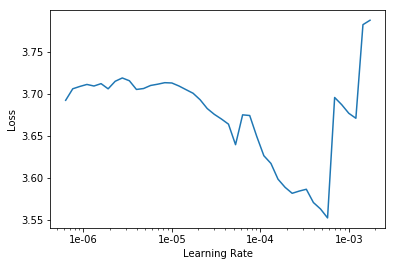

In [276]:
learn.recorder.plot(skip_end=5)

In [295]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,time
0,3.655363,3.580714,00:21


In [296]:
data.classes

['background',
 '/m/011k07',
 '/m/01226z',
 '/m/0138tl',
 '/m/014sv8',
 '/m/015h_t',
 '/m/015p6',
 '/m/0167gd',
 '/m/0174n1',
 '/m/017ftj',
 '/m/018p4k',
 '/m/0199g',
 '/m/019jd',
 '/m/01_bhs',
 '/m/01bfm9',
 '/m/01bjv',
 '/m/01bqk0',
 '/m/01d40f',
 '/m/01fdzj',
 '/m/01g317',
 '/m/01jfm_',
 '/m/01llwg',
 '/m/01mzpv',
 '/m/01n4qj',
 '/m/01n5jq',
 '/m/01prls',
 '/m/01tcjp',
 '/m/01ww8y',
 '/m/01x_v',
 '/m/01xgg_',
 '/m/01xyhv',
 '/m/01yx86',
 '/m/020jm',
 '/m/0220r2',
 '/m/025dyy',
 '/m/025nd',
 '/m/0270h',
 '/m/0271t',
 '/m/0283dt1',
 '/m/0284d',
 '/m/02_n6y',
 '/m/02dgv',
 '/m/02dl1y',
 '/m/02g30s',
 '/m/02p0tk3',
 '/m/02wbm',
 '/m/02xwb',
 '/m/02y6n',
 '/m/03120',
 '/m/032b3c',
 '/m/0342h',
 '/m/035r7c',
 '/m/039xj_',
 '/m/03bk1',
 '/m/03bt1vf',
 '/m/03fp41',
 '/m/03jm5',
 '/m/03k3r',
 '/m/03p3bw',
 '/m/03q69',
 '/m/03vt0',
 '/m/0463sg',
 '/m/04_sv',
 '/m/04bcr3',
 '/m/04dr76w',
 '/m/04hgtk',
 '/m/04rky',
 '/m/04v6l4',
 '/m/04vv5k',
 '/m/04yx4',
 '/m/050gv4',
 '/m/050k8',
 '/m/052lwg6

In [297]:
learn.unfreeze()

In [302]:
learn.fit_one_cycle(1, slice(1e-6, 5e-5))

epoch,train_loss,valid_loss,time
0,2.897840,3.148055,00:20
